# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 2. Load and Explore Data

In [2]:
#! loading dataset fron github repo
url = "https://raw.githubusercontent.com/srinivem/Federal-Interest-Rates-Prediction-for-2025/lstm_model/finaldata.csv"

print("Loading data...")

#! loading data into pandas dataframe
data = pd.read_csv(url)
print(f"Data loaded: {data.shape[0]} rows, {data.shape[1]} columns.")

Loading data...
Data loaded: 844 rows, 5 columns.


In [3]:
#! datset preview
print(data.head())

         Date  Inflation Rate  Unemployment Rate  Bonds Yield  FEDFUNDS
0  1954-07-01             0.4                5.8         2.89      0.80
1  1954-08-01             0.0                6.0         2.87      1.22
2  1954-09-01            -0.4                6.1         2.89      1.07
3  1954-10-01            -0.7                5.7         2.87      0.85
4  1954-11-01            -0.4                5.3         2.89      0.83


# 3. Handle Missing Values

In [4]:
#! checking for missing values
missing_values = data.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Date                 0
Inflation Rate       0
Unemployment Rate    0
Bonds Yield          0
FEDFUNDS             0
dtype: int64


In [5]:
#! adding lagged features for the FEDFUNDS column
data['FEDFUNDS_Lag1'] = data['FEDFUNDS'].shift(1)
data['FEDFUNDS_Lag2'] = data['FEDFUNDS'].shift(2)

In [6]:
#! checking for missing values after  laagged features
missing_values = data.isnull().sum()

print("Missing values in each column after adding lagged features:")
print(missing_values)

Missing values in each column after adding lagged features:
Date                 0
Inflation Rate       0
Unemployment Rate    0
Bonds Yield          0
FEDFUNDS             0
FEDFUNDS_Lag1        1
FEDFUNDS_Lag2        2
dtype: int64


In [7]:
#! dropping missing value rows
data = data.dropna()

#! checking for missing values
print("Missing values after dropping rows:")
print(data.isnull().sum())

Missing values after dropping rows:
Date                 0
Inflation Rate       0
Unemployment Rate    0
Bonds Yield          0
FEDFUNDS             0
FEDFUNDS_Lag1        0
FEDFUNDS_Lag2        0
dtype: int64


# 4. Data Manipulation and Feature Engineering

In [8]:
#! extracting month from date column to capture seasonality
data['Month'] = pd.to_datetime(data['Date']).dt.month

#! one hot encoding - Month column
data = pd.get_dummies(data, columns=['Month'], drop_first=True)

#! defining features and target
TARGET = 'FEDFUNDS'
FEATURES = ['Inflation Rate', 'Unemployment Rate', 'Bonds Yield', 'FEDFUNDS_Lag1', 'FEDFUNDS_Lag2'] + [col for col in data.columns if col.startswith('Month_')]

# 5. Data Preprocessing

In [9]:
#! extracting features and target
features = data[FEATURES].values
target = data[TARGET].values

#! scaling features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

#! scaling the target variable
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()

# 6. Sequence Preparation for LSTM

In [10]:
#! defining sequence length
SEQ_LEN = 12    #! sequence length (past 12 months)
#! sequences
X, y = [], []
for i in range(SEQ_LEN, len(scaled_features)):
    X.append(scaled_features[i - SEQ_LEN:i])    #! input - past 12 months data
    y.append(target_scaled[i])    #! target value

#! converting seqqunces to numpy
X, y = np.array(X), np.array(y)

# 7. Train-Test Split

In [11]:
#! splitting into training and testing datasets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 664, Testing samples: 166


# 8. Model Creation and Training

In [12]:
#! LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),  # Regularization to prevent overfitting
    Dense(1, kernel_regularizer=l2(0.01))  # L2 regularization
])

#! model compilation
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          13,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,451 (52.54 KB)

 Trainable params: 13,451 (52.54 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#! early stopping for overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#! training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0906 - val_loss: 0.0472
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0392 - val_loss: 0.0311
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324 - val_loss: 0.0293
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0302 - val_loss: 0.0242
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0265 - val_loss: 0.0227
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - val_loss: 0.0201
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0232 - val_loss: 0.0213
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0235 - val_loss: 0.0187
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0253 - val_loss: 0.0176
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0221 - val_loss: 0.0189
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0228 - val_loss: 0.0176
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0214 - val_l

# 9. Model Evaluation

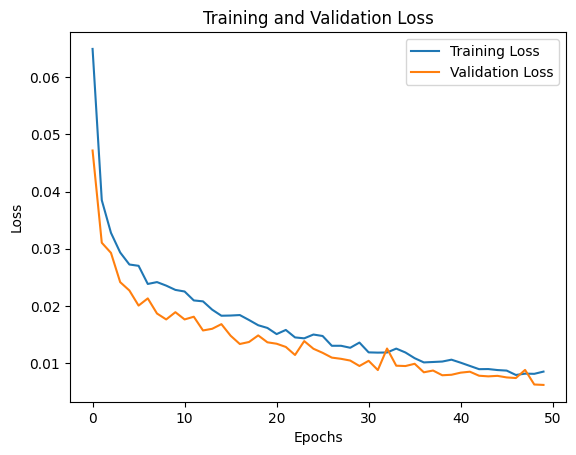

In [14]:
#! plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
#! model prediction
predictions = model.predict(X_test)

#! rescaling predictions and actual values
predictions_rescaled = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

#! calculating MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error (Rescaled): {mse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Mean Squared Error (Rescaled): 1.0542


# 10. Visualize Predictions

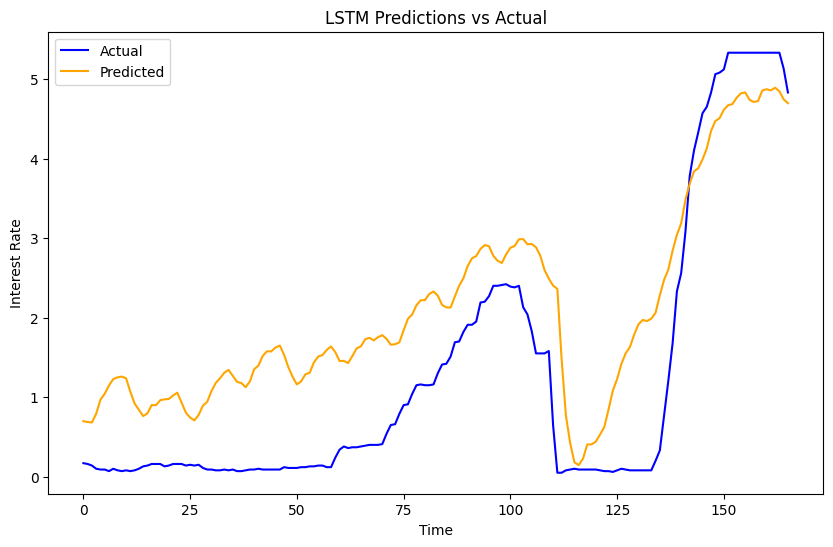

In [16]:
#! plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(predictions_rescaled, label='Predicted', color='orange')
plt.title("LSTM Predictions vs Actual")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.legend()
plt.show()